In [1]:
# IPython magic tools
%load_ext autoreload
%autoreload 2

# Standard library imports
import os
from os import PathLike
import subprocess
from pathlib import Path
from io import BytesIO
from datetime import datetime
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use a non-GUI backend

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import seaborn as sns
import cv2
import pytz
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display

# Custom library imports
from aind_vr_foraging_analysis.utils.parsing import parse, data_access

# Pandas & warning config
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Seaborn context
sns.set_context("talk")

# Color definitions
color1 = '#d95f02'
color2 = '#1b9e77'
color3 = '#7570b3'
color4 = 'yellow'
odor_list_color = [color1, color2, color3, color4]

color_dict_label = {
    'InterSite': '#808080',
    'InterPatch': '#b3b3b3', 
    'PatchZA': '#d95f02', 'PatchZB': '#d95f02', 
    'PatchB': '#d95f02', 'PatchA': '#7570b3', 
    'PatchC': '#1b9e77',
    'Alpha-pinene': '#1b9e77', 
    'Methyl Butyrate': '#7570b3', 
    'Amyl Acetate': '#d95f02', 
    'Fenchone': '#7570b3', 
    'S': color1,
    'D': color2,
    'N': color3,
}

label_dict = {
    **{"InterSite": '#808080', "InterPatch": '#b3b3b3'}, 
    **color_dict_label
}

# Function to assign codes
def get_condition_code(text):
    if 'delayed' in text:
        return 'D'
    elif 'single' in text:
        return 'S'
    elif 'no_reward' in text or 'noreward' in text:
        return 'N'
    elif 'double' in text:
        return 'Do'
    else:
        return text

# File paths
pdf_path = r'\\allen\aind\scratch\vr-foraging\sessions'
# foraging_figures = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents'
foraging_figures = r'C:\Users\jason.lee\OneDrive - Allen Institute\Documents\patch_foraging'


In [2]:
class MetricsVrForaging():
    def __init__(self, session_path: PathLike):
        self.session_path = session_path
        self.active_site, self.stream_data, self.data = data_access.load_session(
        session_path
        )
        
        self.reward_sites = self.active_site.loc[self.active_site['label'] == 'OdorSite']
        self.session = self.data['config'].streams.session_input.data['date'][:10]
        self.mouse = int(self.data['config'].streams.session_input.data['subject'])
        self.stage = self.data['config'].streams.tasklogic_input.data['stage_name']
        self.rig_name = self.data['config'].streams.rig_input.data['rig_name']
        self.experimenter = self.data['config'].streams.session_input.data['experimenter'][0]
        self.updaters = self.data['config'].streams.tasklogic_input.data['task_parameters']['updaters']

        # print(self.rig_name)
        # print(self.stage)
        # print(self.experimenter)
        
        if self.stage == 'thermistor screening':
            return
        
        self.df = self.retrieve_metrics()

    def retrieve_metrics(self) -> pd.DataFrame:
        reward_sites = self.reward_sites
        active_site = self.active_site
        data = self.data

        df = pd.DataFrame()
        # Summary of different relevants aspects -------------------------------------------------

        unrewarded_stops = reward_sites.loc[reward_sites.is_reward==0]['reward_amount'].count()
        rewarded_stops = reward_sites.loc[reward_sites.is_reward==1]['reward_amount'].count()
        water_collected = reward_sites.loc[(reward_sites['is_reward']==1)]['reward_amount'].sum()
        total_stops = reward_sites.loc[(reward_sites['is_choice']==True)]['reward_amount'].count()

        # print('Total sites: ' ,len(reward_sites), ' | ', 'Total rewarded stops: ',rewarded_stops, '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
        #    'Total unrewarded stops: ',unrewarded_stops,'(',  np.round((unrewarded_stops/total_stops)*100,2),'%) | ','Water consumed: ', water_collected, 'ul')

        # print('Total travelled m: ', np.round(active_site.start_position.max()/100,2), ', current position (cm): ', data['operation_control'].streams.CurrentPosition.data.max()[0])

        for odor_label in reward_sites.odor_label.unique():
            values = reward_sites.loc[(reward_sites['odor_label']==odor_label)&(reward_sites['is_reward']==1)]['reward_amount'].sum()
            # print(f'{odor_label} {values} ul')
            
        df.at[0,'odor_sites_travelled'] = int(len(reward_sites))
        df.at[0,'distance_m'] = data['operation_control'].streams.CurrentPosition.data.max()[0]/100
        df.at[0,'water_collected_ul'] = water_collected
        df.at[0,'rewarded_stops'] = int(rewarded_stops)
        df.at[0,'total_stops'] = int(total_stops)
        df.at[0,'session_duration_min'] = (reward_sites.index[-1] - reward_sites.index[0])/60
        df.at[0, 'total_patches_visited'] = reward_sites.loc[reward_sites['site_number'] >= 1].patch_number.nunique()
        return df

    def retrieve_updater_values(self):
        # Initialize a pointer for the data values
        data_pointer = 0
        
        reward_sites = self.reward_sites
        data = self.data
        df = self.df
        
        # Helper function to safely extract stream data
        def get_stream_data(data, key):
            try:
                stream = data['updater_events'].streams[key].data['data']
                stream.reset_index(drop=True, inplace=True)
                return stream
            except (KeyError, AttributeError):
                return None

        # Load updater data safely
        stop_duration = get_stream_data(data, 'UpdaterStopDurationOffset')
        delay = get_stream_data(data, 'UpdaterRewardDelayOffset')
        velocity_threshold = get_stream_data(data, 'UpdaterStopVelocityThreshold')

        ## print(stop_duration)
        # Create new columns in reward_sites with default values
        reward_sites['delay_s'] = np.nan
        reward_sites['velocity_threshold_cms'] = np.nan
        reward_sites['stop_duration_s'] = np.nan

        data_pointer = 0
        try:
            for index, row in reward_sites.iterrows():
                if row['is_reward'] == 1:
                    if delay is not None and len(delay) > data_pointer:
                        reward_sites.at[index, 'delay_s'] = delay[data_pointer]
                    if velocity_threshold is not None and len(velocity_threshold) > data_pointer:
                        reward_sites.at[index, 'velocity_threshold_cms'] = velocity_threshold[data_pointer]
                    if stop_duration is not None and len(stop_duration) > data_pointer:
                        reward_sites.at[index, 'stop_duration_s'] = stop_duration[data_pointer]
                    data_pointer += 1
                else:
                    if delay is not None and len(delay) > data_pointer:
                        reward_sites.at[index, 'delay_s'] = delay[data_pointer]
                    if velocity_threshold is not None and len(velocity_threshold) > data_pointer:
                        reward_sites.at[index, 'velocity_threshold_cms'] = velocity_threshold[data_pointer]
                    if stop_duration is not None and len(stop_duration) > data_pointer:
                        reward_sites.at[index, 'stop_duration_s'] = stop_duration[data_pointer]
        except IndexError:
            if delay is not None:
                reward_sites.at[index, 'delay_s'] = delay.max()
            if velocity_threshold is not None:
                reward_sites.at[index, 'velocity_threshold_cms'] = velocity_threshold.max()
            if stop_duration is not None:
                reward_sites.at[index, 'stop_duration_s'] = stop_duration.max()

        # Summary of the training metrics
        reward_sites['odor_sites'] = np.arange(1, len(reward_sites) + 1)

        # Safely update df only if values exist
        if delay is not None:
            df.at[0, 'start_delay'] = reward_sites['delay_s'].min()
            df.at[0, 'end_delay'] = reward_sites['delay_s'].max()
            df.at[0, 'sites_to_max_delay'] = reward_sites[reward_sites['delay_s'] == reward_sites['delay_s'].max()].iloc[0]['odor_sites']

        if stop_duration is not None:
            df.at[0, 'start_stop_duration'] = reward_sites['stop_duration_s'].min()
            df.at[0, 'end_stop_duration'] = reward_sites['stop_duration_s'].max()
            df.at[0, 'sites_to_max_stop_duration'] = reward_sites[reward_sites['stop_duration_s'] == reward_sites['stop_duration_s'].max()].iloc[0]['odor_sites']
            df.at[0, 'rewarded_sites_in_max_stop'] = int(reward_sites[(reward_sites['stop_duration_s'] == reward_sites['stop_duration_s'].max()) & (reward_sites.is_choice == 1)]['odor_sites'].nunique())

        if velocity_threshold is not None:
            df.at[0, 'start_velocity_threshold'] = reward_sites['velocity_threshold_cms'].min()
            df.at[0, 'end_velocity_threshold'] = reward_sites['velocity_threshold_cms'].max()
            df.at[0, 'target_max_velocity_threshold'] = reward_sites['velocity_threshold_cms'].max()
            df.at[0, 'sites_to_min_velocity'] = reward_sites[reward_sites['velocity_threshold_cms'] == reward_sites['velocity_threshold_cms'].min()].iloc[0]['odor_sites']
            df.at[0, 'sites_to_max_velocity'] = reward_sites[reward_sites['velocity_threshold_cms'] == reward_sites['velocity_threshold_cms'].max()].iloc[0]['odor_sites']        
        
        self.reward_sites = reward_sites
        self.df = df

    def get_metrics(self):
        return self.df

    def get_reward_sites(self):
        return self.reward_sites
    
    def get_mouse_and_session(self):
        return self.mouse, self.session
    
    def run_pdf_summary(self):
        color1='#d95f02'
        color2='#1b9e77'
        color3='#7570b3'
        color4='#e7298a'

        color_dict_label = {'InterSite': '#808080',
            'InterPatch': '#b3b3b3', 'PatchZ': '#d95f02',
            'PatchZA': '#d95f02', 'PatchZB': '#d95f02', 
            'PatchB': '#d95f02','PatchA': '#7570b3', 
            'PatchC': '#1b9e77',
            'Alpha-pinene': '#1b9e77', 
            'Methyl Butyrate': '#7570b3', 
            'Amyl Acetate': '#d95f02', 
            'Fenchone': '#7570b3', 
            'Dipropyl sulfide': '#7570b3',
            'Hexanal': '#1b9e77',
            'Pentyl acetate': '#d95f02',
            'S': color1,
            'D': color2,
            'N': color3,   
            'Do': color1,
            'None': color4
            }
        
        odor_sites = self.reward_sites.copy()
        encoder_data = self.stream_data.encoder_data
        active_site = self.active_site.copy()
        
        active_site['mouse'] = self.mouse
        active_site['session'] = self.session
        
        # Apply function
        active_site['long_patch_label'] = active_site['patch_label']
        active_site['patch_label'] = active_site['patch_label'].apply(get_condition_code)
        
        # odor_sites['odor_label'] = odor_sites['odor_label'].str.replace(' ', '_')
        
        # Remove segments where the mouse was disengaged
        last_engaged_patch = odor_sites['patch_number'][odor_sites['skipped_count'] >= 10].min()
        if pd.isna(last_engaged_patch):
            last_engaged_patch = odor_sites['patch_number'].max()
            
        odor_sites['engaged'] = odor_sites['patch_number'] <= last_engaged_patch  
    
        try:
            odor_sites['block'] = odor_sites['patch_label'].str.extract(r'set(\d+)').astype(int)
        except ValueError: 
            odor_sites['block'] = 0

        # Apply function
        odor_sites['long_patch_label'] = odor_sites['patch_label']
        odor_sites['patch_label'] = odor_sites['patch_label'].apply(get_condition_code)
        
        trial_summary = plotting.trial_collection(odor_sites[['is_choice', 'site_number', 'odor_label', 'depleted', 'odor_sites', 'is_reward','reward_probability','reward_amount','reward_available']], 
                                                  encoder_data, 
                                                  window=(-1,3)
                                                )
    
        # Save each figure to a separate page in the PDF
        pdf_filename = f'{self.mouse}_{self.session}_summary.pdf'
        with PdfPages(pdf_path+"\\"+pdf_filename) as pdf:
            text1 = ('Mouse: ' + str(self.mouse) 
            + '\nSession: ' + str(self.session) 
            + '\nRig: ' + str(self.rig_name) 
            + '\nStage: ' + str(self.stage)
            + '\nTotal sites: '  + str(self.df.total_stops.iloc[0]) 
            + '\nTotal rewarded stops: ' + str(self.df.rewarded_stops.iloc[0]) + ' (' +str(np.round((self.df.rewarded_stops.iloc[0]/self.df.total_stops.iloc[0])*100,2)) + '%) \n' 
            + 'Water consumed: ' +  str(np.round(self.df.water_collected_ul.iloc[0], 2)) + 'ul\n' 
            + 'Session duration: ' + str(np.round(self.df.session_duration_min.iloc[0],2)) + 'min\n' 
            + 'Total travelled m: ' + str(np.round(active_site.start_position.max()/100,2))
            )
            
            # '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
            text_to_figure = text1
            # if self.stage[:7] == 'shaping':
            #     text2 = '\nTotal sites travelled: ' + str(self.df.odor_sites_travelled.iloc[0]) + '\nRewarded stops in max stop duration: ' + str(self.df.rewarded_sites_in_max_stop.iloc[0]) + '\nTotal patches visited: ' + str(self.df.total_patches_visited.iloc[0])
            #     text_to_figure = text1 + text2
            
            # Create a figure
            fig, ax = plt.subplots(figsize=(8.5, 11))  # Standard letter size
            ax.text(0.1, 0.9, text_to_figure, ha='left', va='center', fontsize=12)
            ax.axis('off')  # Hide the axes
            pdf.savefig(fig)
            plt.close(fig)
            
            # plotting.raster_with_velocity(active_site, stream_data, color_dict_label=color_dict_label, save=pdf)
            plotting.segmented_raster_vertical(odor_sites, 
                                            save=False, 
                                            color_dict_label=color_dict_label)
            plotting.raster_with_velocity(active_site, self.stream_data, color_dict_label=color_dict_label, save=pdf)
        
            plotting.summary_withinsession_values(odor_sites, 
                                    color_dict_label = color_dict_label, 
                                    save=pdf)
            plotting.speed_traces_efficient(trial_summary, self.mouse, self.session,  save=pdf)
            plotting.preward_estimates(odor_sites, 
                                    color_dict_label = color_dict_label, 
                                    save=pdf)
            plotting.speed_traces_value(trial_summary, self.mouse, self.session, condition = 'reward_probability', save=pdf) 
            plotting.velocity_traces_odor_entry(trial_summary, max_range = trial_summary.speed.max(), color_dict_label=color_dict_label, save=pdf)

            plotting.length_distributions(self.active_site, self.data, delay=True, save=pdf)
            if len(self.updaters):
                plotting.update_values(self.reward_sites, save=pdf)
            
        return pdf_filename

In [3]:
### Load Patch Foraging Data

#FIP_test_session = r'\\allen\aind\scratch\vr-foraging\data\778334\fip_test_as_781896\781896_2025-07-18T192910Z'

# session_paths = data_access.find_sessions_relative_to_date(
#     mouse = "781896",
#     date_string = "2025-6-13",
#     when = 'on'
# )


# all_epochs, stream_data, data = data_access.load_session(
#     session_paths[0]
# )

session_path = r'\\allen\aind\scratch\vr-foraging\data\778334\fip_test_as_781896\781896_2025-07-18T192910Z'
all_epochs, stream_data, data = data_access.load_session(session_path)


all_epochs['patch_label'] = all_epochs['patch_label'].apply(get_condition_code)
# all epochs gives you a trial-based table segmented by interpatch, intersite or odorsite. Stream_data gives access to continuous data parsed for interpretability. 

In [4]:
parsed_session = MetricsVrForaging(session_path)
parsed_session.get_reward_sites().columns

Index(['label', 'start_position', 'length', 'friction', 'patch_number',
       'patch_label', 'odor_label', 'site_number', 'stop_time',
       'choice_cue_time', 'reward_onset_time', 'succesful_wait_time',
       'is_choice', 'is_reward', 'reward_amount', 'reward_probability',
       'reward_available', 'odor_sites', 'collected', 'depleted', 'last_visit',
       'last_site', 'cumulative_rewards', 'consecutive_rewards',
       'cumulative_failures', 'consecutive_failures',
       'after_choice_cumulative_rewards', 'duration_epoch', 'patch_onset',
       'time_since_entry', 'exit_epoch', 'skipped_count'],
      dtype='object')

In [ ]:
parsed_session.get_reward_sites()['patch_onset']

In [5]:
patch_start_times = all_epochs.loc[all_epochs['label'] == 'InterPatch'].index
patch_end_times = patch_start_times[1:].append(pd.Index([all_epochs.index[-1]]))  # Next patch's start time as end time for the last one
patches = list(zip(patch_start_times, patch_end_times))
patch_start_times

Index([934190.896032, 934239.406016, 934299.654016, 934360.942016,
       934449.542016, 934739.078016, 934769.326016, 934785.380032,
       935064.734016],
      dtype='float64', name='start_time')

In [8]:
all_epochs

,label,start_position,length,friction,patch_number,patch_label,odor_label,site_number,stop_time,choice_cue_time,...,cumulative_rewards,consecutive_rewards,cumulative_failures,consecutive_failures,after_choice_cumulative_rewards,duration_epoch,patch_onset,time_since_entry,exit_epoch,skipped_count
start_time,,,,,,,,,,,,,,,,,,,,,
934190.896032,InterPatch,0.028762,238.634897,0.0,0,PatchA,Alpha-pinene,NaN,934207.682016,NaN,...,NaN,NaN,NaN,NaN,NaN,16.785984,934207.682016,-16.785984,0.000000,NaN
934207.682016,InterSite,238.663660,40.914596,0.0,0,PatchA,Alpha-pinene,NaN,934215.520032,NaN,...,NaN,NaN,NaN,NaN,NaN,7.838016,934207.682016,0.000000,7.838016,NaN
934215.520032,OdorSite,279.578256,50.000000,0.0,0,PatchA,Alpha-pinene,0.0,934217.940032,NaN,...,0.0,0.0,0.0,0.0,1.0,2.420000,934207.682016,7.838016,10.258016,1.0
934217.940032,InterSite,329.578256,68.278861,0.0,0,PatchA,Alpha-pinene,NaN,934239.406016,NaN,...,NaN,NaN,NaN,NaN,NaN,21.465984,934207.682016,10.258016,31.724000,NaN
934239.406016,InterPatch,397.924194,223.050942,0.0,1,PatchA,Alpha-pinene,NaN,934296.052032,NaN,...,NaN,NaN,NaN,NaN,NaN,56.646016,934296.052032,-56.646016,0.000000,NaN
934296.052032,InterSite,620.975136,21.725429,0.0,1,PatchA,Alpha-pinene,NaN,934297.084032,NaN,...,NaN,NaN,NaN,NaN,NaN,1.032000,934296.052032,0.000000,1.032000,NaN
934297.084032,OdorSite,642.700566,50.000000,0.0,1,PatchA,Alpha-pinene,0.0,934298.670016,NaN,...,0.0,0.0,0.0,0.0,0.0,1.585984,934296.052032,1.032000,2.617984,2.0
934298.670016,InterSite,692.700566,33.788596,0.0,1,PatchA,Alpha-pinene,NaN,934299.654016,NaN,...,NaN,NaN,NaN,NaN,NaN,0.984000,934296.052032,2.617984,3.601984,NaN
934299.654016,InterPatch,726.663940,457.213914,0.0,2,PatchB,Fenchone,NaN,934357.674016,NaN,...,NaN,NaN,NaN,NaN,NaN,58.020000,934357.674016,-58.020000,0.000000,NaN


In [6]:
df = all_epochs.reset_index()

odor_rows = df[df['label'] == 'OdorSite']
intersite_times = df[df['label'] == 'InterSite']['start_time'].values

odor_sites = []
for _, row in odor_rows.iterrows():
    odor_time = row['start_time']
    patch_label = row['patch_label']

    future_intersites = intersite_times[intersite_times > odor_time]
    if len(future_intersites) > 0:
        next_intersite = future_intersites[0]
        odor_sites.append((odor_time, next_intersite, patch_label))

print(odor_sites)



[(934215.520032, 934217.940032, 'PatchA'), (934297.084032, 934298.670016, 'PatchA'), (934358.536032, 934359.968032, 'PatchB'), (934445.766016, 934448.046016, 'PatchA'), (934697.042016, 934701.242016, 'PatchB'), (934702.624032, 934705.950016, 'PatchB'), (934767.208032, 934768.700032, 'PatchA'), (934782.350016, 934784.394016, 'PatchC'), (935061.208032, 935063.772032, 'PatchA')]


In [27]:
stream_data.encoder_data.filtered_velocity

Time
934187.32784    NaN
934187.33184    NaN
934187.33584    NaN
934187.33984    NaN
934187.34384    NaN
               ... 
935171.55648    0.0
935171.56048    0.0
935171.56448    0.0
935171.56848    0.0
935171.57248    0.0
Name: filtered_velocity, Length: 246063, dtype: float64

In [7]:
### Load FIP data

FIP_Dir = r'\\allen\aind\scratch\vr-foraging\data\778334\fip_test_as_781896\781896_2025-07-18T192910Z\fib\test_2025-07-18T192959Z'
subjectID = "778334"

import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import csv
import glob
import re
from scipy.optimize import curve_fit
import json
import pandas as pd
from scipy.stats import sem

import PreprocessingFunctions_v2 as pf

# for visualization
Roi2Vis = [0]    
AllPlot = 0

# params for pre-processing
nFrame2cut = 100  # crop initial n frames
sampling_rate = 10  # individual channel (not total)
kernelSize = 1  # median filter
degree = 4  # polyfit
b_percentile = 0.70  # To calculate F0, median of bottom x%

StimPeriod = 0.5  # sec for visualization
preW = 50  # nframes for PSTH
LickWindow = 5.0  # sec window length for Consummatory/Omission licks

try: 
    file1 = glob.glob(FIP_Dir + os.sep + "FIP_DataIso_*")[0]
    
except Exception as e:
    file1 = glob.glob(FIP_Dir + os.sep + "iso.csv")[0]
    file2 = glob.glob(FIP_Dir + os.sep + "green.csv")[0]
    file3 = glob.glob(FIP_Dir + os.sep + "red.csv")[0]   
    
else:
    file2 = glob.glob(FIP_Dir + os.sep + "green.csv")[0]
    file3 = glob.glob(FIP_Dir + os.sep + "red.csv")[0]

with open(file1) as f:
    reader = csv.reader(f)
    datatemp = np.array([row for row in reader])
    data1 = datatemp[1:,:].astype(np.float32)
    # del datatemp
    
with open(file2) as f:
    reader = csv.reader(f)
    datatemp = np.array([row for row in reader])
    data2 = datatemp[1:,:].astype(np.float32)
    # del datatemp
    
with open(file3) as f:
    reader = csv.reader(f)
    datatemp = np.array([row for row in reader])
    data3 = datatemp[1:,:].astype(np.float32)
    # del datatemp

#%%
# in case acquisition halted accidentally
Length = np.amin([len(data1),len(data2),len(data3)])

data1 = data1[0:Length] # iso       Time*[TS,ROI0,ROI1,ROI2,..]
data2 = data2[0:Length] # signal
data3 = data3[0:Length] # Stim

PMts = data2[:,0] #SignalTS
time_seconds = np.arange(len(data1)) /sampling_rate

#%% Preprocess
Ctrl_dF_F = np.zeros((data1.shape[0],data1.shape[1]))
G_dF_F = np.zeros((data1.shape[0],data1.shape[1]))
R_dF_F = np.zeros((data1.shape[0],data1.shape[1]))

for ii in range(data2.shape[1]-4):  # -4 to skip the first 4 columns (Fiber 0-3 are columns 4-7)
    Ctrl_dF_F[:, ii] = pf.tc_preprocess(data1[:,ii+4], nFrame2cut, kernelSize, sampling_rate, degree, b_percentile)
    G_dF_F[:, ii] = pf.tc_preprocess(data2[:,ii+4] , nFrame2cut, kernelSize, sampling_rate, degree, b_percentile)
    R_dF_F[:, ii] = pf.tc_preprocess(data3[:,ii+4] , nFrame2cut, kernelSize, sampling_rate, degree, b_percentile)
    


In [9]:
#%% PSTH functions (for multiple traces)
def PSTHmaker(TC, Stims, preW, postW):
    cnt = 0  
    if Stims - preW >= 0 and  Stims + postW < len(TC):
        A = int(Stims-preW) 
        B = int(Stims+postW)  
        if cnt == 0:
            PSTHout = TC[A:B,:]
            cnt = 1
        else:
            PSTHout = np.dstack([PSTHout,TC[A:B,:]])
    else:
        if cnt == 0:
            PSTHout = np.zeros(preW+postW)
            cnt = 1
        #else:
            #PSTHout = np.dstack([PSTHout, np.zeros(preW+postW)])
    return PSTHout

#%%
def PSTHplot(PSTH, MainColor, SubColor, LabelStr):
    plt.plot(np.arange(np.shape(PSTH)[1])/20 - preW/sampling_rate, np.mean(PSTH.T,axis=1),label=LabelStr,color = MainColor, linewidth=0.5)
    #plt.plot(np.arange(np.shape(PSTH)[1])/20 - 5, np.mean(PSTH.T,axis=1) + np.std(PSTH.T,axis=1)/np.sqrt(np.shape(PSTH)[0]),color = SubColor, linestyle = "dotted")
    #plt.plot(np.arange(np.shape(PSTH)[1])/20 - 5, np.mean(PSTH.T,axis=1) - np.std(PSTH.T,axis=1)/np.sqrt(np.shape(PSTH)[0]),color = SubColor, linestyle = "dotted")
    # y11 =  np.mean(PSTH.T,axis=1) + np.std(PSTH.T,axis=1)/np.sqrt(np.shape(PSTH)[0])
    # y22 =  np.mean(PSTH.T,axis=1) - np.std(PSTH.T,axis=1)/np.sqrt(np.shape(PSTH)[0])
    # plt.fill_between(np.arange(np.shape(PSTH)[1])/20 - preW/sampling_rate, y11, y22, facecolor=SubColor, alpha=0.5)


#%% PSTH baseline subtraction (multi)
#dim0:trial, dim1:time
def PSTH_baseline(PSTH, preW):
   
    Trace_this = PSTH[:, :]
    Trace_this_base = Trace_this[0:preW,:]
    Trace_this_subtracted = Trace_this - np.mean(Trace_this_base,axis=0)

    PSTHbase = Trace_this_subtracted

    return PSTHbase

In [12]:
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'      # keep text selectable in SVG
mpl.rcParams['savefig.transparent'] = True # optional: transparent background

def plot_FIP_odorsite(patch_num, fiber_nums, save_svg=None, show=True):
    # %matplotlib inline  # <- keep this OUTSIDE functions if you’re in a notebook

    preW = 50
    start, odor_end, patch_label = odor_sites[patch_num]

    color_map = {'PatchA': 'red', 'PatchB': 'blue', 'PatchC': 'green'}
    colorcode = color_map.get(patch_label, 'gray')

    plot_end = odor_end + 5  # extend visualization window

    # Frame indexing based on time
    startFrame = np.argmin(np.abs(data1[:, 0] - start))
    endFrame   = np.argmin(np.abs(data1[:, 0] - plot_end))

    # Generate PSTHs and baseline-correct
    Psth_G = PSTHmaker(G_dF_F * 100, startFrame, preW, endFrame - startFrame)
    Psth_R = PSTHmaker(R_dF_F * 100, startFrame, preW, endFrame - startFrame)
    Psth_C = PSTHmaker(Ctrl_dF_F * 100, startFrame, preW, endFrame - startFrame)

    Psth_G_base = PSTH_baseline(Psth_G, preW)
    Psth_R_base = PSTH_baseline(Psth_R, preW)
    Psth_C_base = PSTH_baseline(Psth_C, preW)

    # Create subplots: one per fiber + one for velocity
    n_fibers = len(fiber_nums)
    fig, axes = plt.subplots(n_fibers + 1, 1, figsize=(10, 2.5 * (n_fibers + 1)), sharex=True)
    fig.suptitle(f'Odor Site {patch_num}, {patch_label}', fontsize=11)

    # Shared time vector for PSTHs
    psth_time = np.arange(Psth_G_base.shape[0]) / sampling_rate - preW / sampling_rate

    # Plot each fiber's dF/F
    for i, fiber_num in enumerate(fiber_nums):
        ax = axes[i]
        ax.plot(psth_time, Psth_G_base[:, fiber_num], label="Green- dLight", linewidth=0.5, color="g")
        ax.plot(psth_time, Psth_R_base[:, fiber_num], label="Red- rACh",   linewidth=0.5, color="r")
        ax.plot(psth_time, Psth_C_base[:, fiber_num], label="Iso",         linewidth=0.5, color="b")
        ax.axvspan(0, odor_end - start, color=colorcode, alpha=0.3)
        ax.set_ylabel(f'dF/F (%)\nFiber {fiber_num}')
        ax.set_xlim(psth_time.min(), psth_time.max())
        if i == 0:
            ax.legend(loc='upper right', fontsize=6)

    # Plot velocity in final subplot
    ax_vel = axes[-1]
    velocity = stream_data.encoder_data.filtered_velocity[start - int(preW / sampling_rate):plot_end]
    velocity_time = np.arange(len(velocity)) / 250 - preW / sampling_rate
    ax_vel.plot(velocity_time, velocity)
    ax_vel.axvspan(0, odor_end - start, color=colorcode, alpha=0.3)
    ax_vel.set_ylabel('Velocity (cm/s)')
    ax_vel.set_xlabel('Time from odor onset (s)')

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # --- NEW: save as SVG (vector) if requested ---
    if save_svg is not None:
        from pathlib import Path
        save_svg = Path(save_svg)
        if save_svg.suffix.lower() != ".svg":
            # Allow passing a directory; auto-name the file
            save_svg.mkdir(parents=True, exist_ok=True)
            save_svg = save_svg / f"FIP_odorsite_patch{patch_num}_{patch_label}.svg"
        fig.savefig(save_svg, format="svg", bbox_inches="tight", metadata={"Creator": "plot_FIP_odorsite"})
        print(f"Saved SVG to {save_svg}")

    if show:
        plt.show()
    else:
        plt.close(fig)



In [ ]:
for i in range(len(odor_sites)):
    plot_FIP_odorsite(i, [0,1], save_svg=foraging_figures)

# Fiber 0 = NAc, Fiber 1 = DMS. Green = dLight, Red = rACh

In [ ]:
for i in range(len(odor_sites)):
    plot_FIP_odorsite(i,[0,1])

# Fiber 0 = NAc, Fiber 1 = DMS. Green = dLight, Red = rACh

Output()

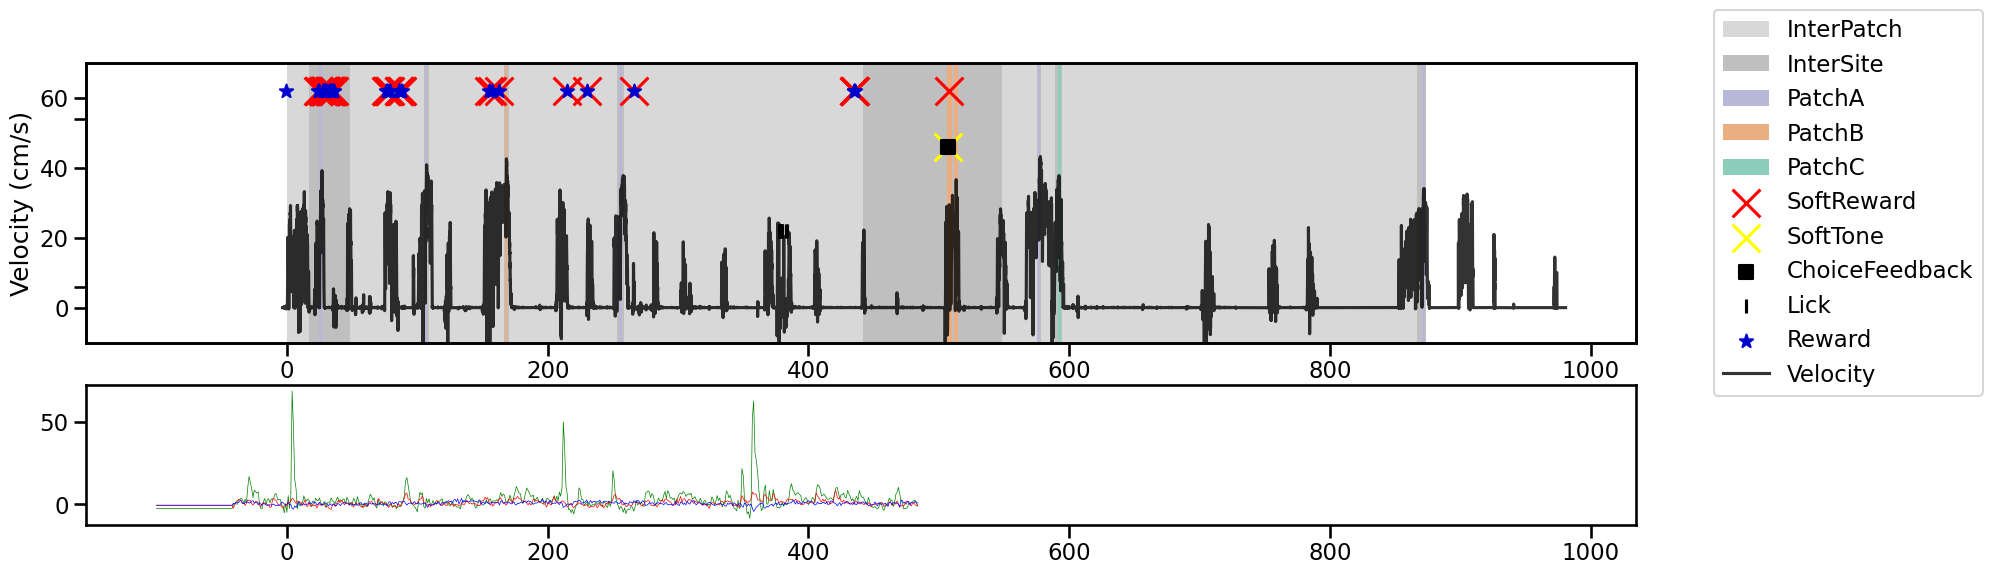

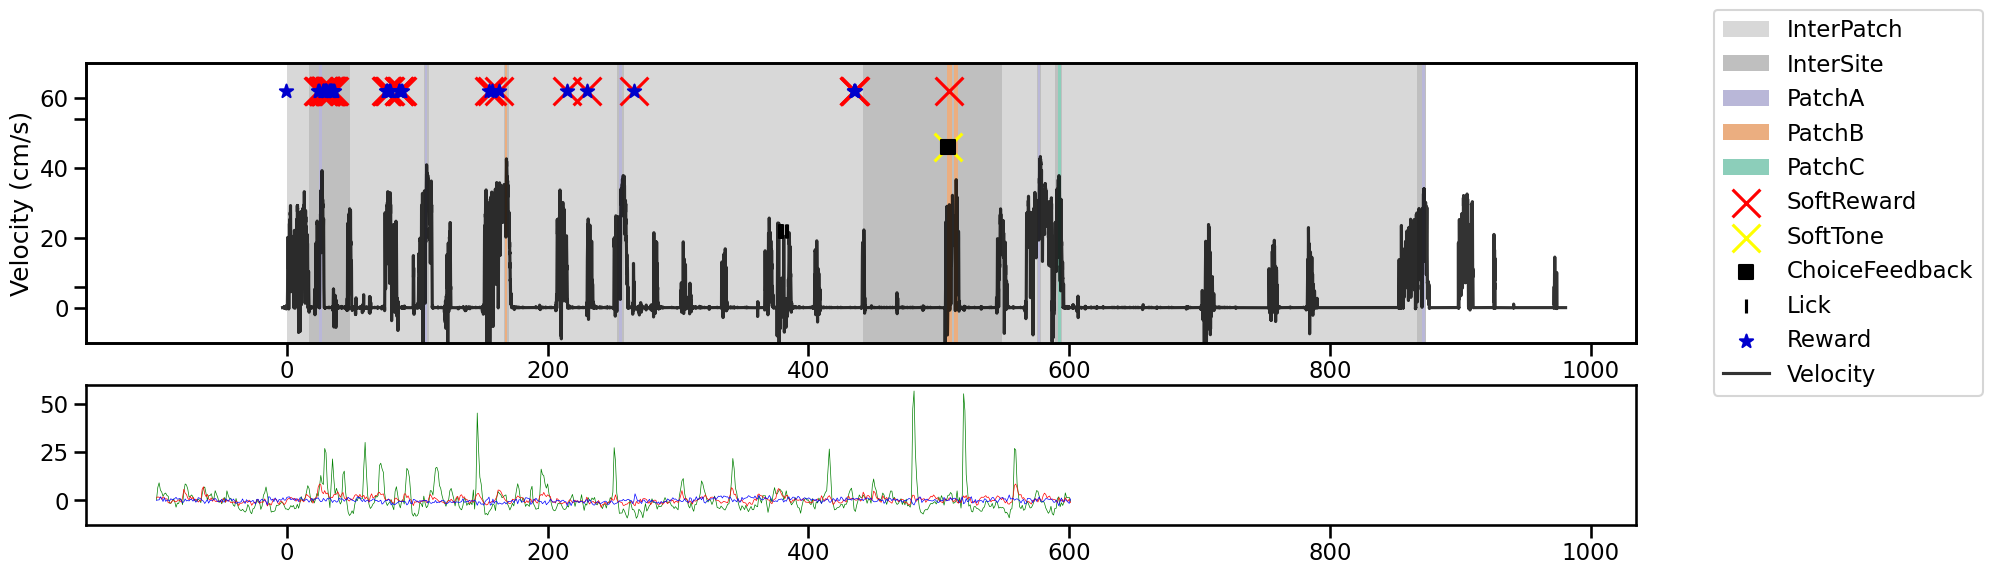

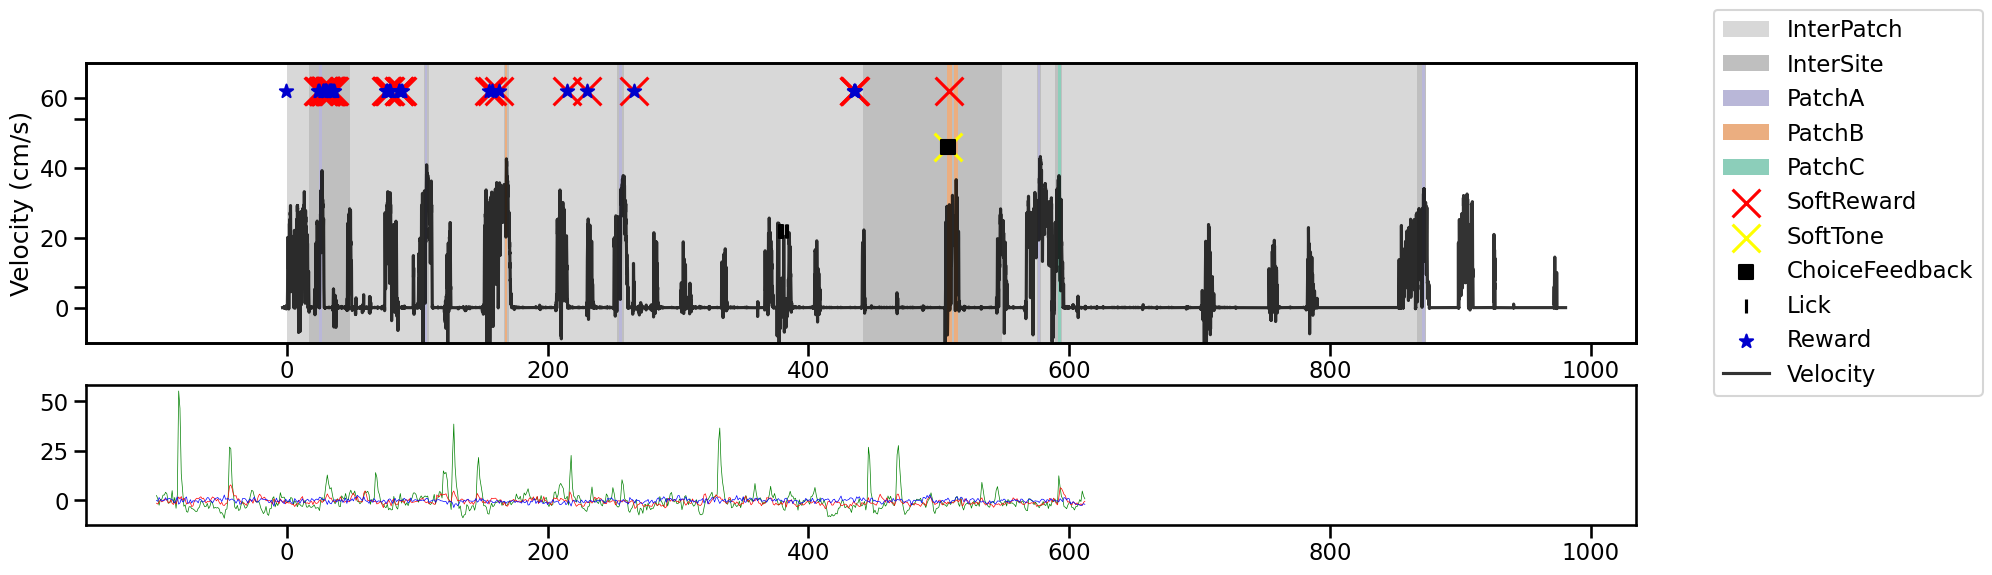

In [ ]:
%matplotlib inline 
def add_position(df: pd.DataFrame, position:  pd.DataFrame):
    position.rename_axis('Time', axis='index', inplace=True)
    df.rename_axis('Time', axis='index', inplace=True)

    df = pd.merge_asof(df.sort_index(), position.sort_index(), direction='nearest', on="Time").set_index("Time").sort_index()
    df.columns = [*df.columns[:-1], 'Position']
    return df

def plot_patches(ax, navigation_mode, zero_index, _legend):
    """Plot the context patches based on the navigation mode."""
    _sites = add_position(all_epochs, position=stream_data.position_data)
    for idx, site in enumerate(all_epochs.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index'] + 1}"
            facecolor = label_dict[site_label]
        elif site_label == "OdorSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        if navigation_mode == "space":
            position = _sites["Position"].values[idx]
            width = _sites["Position"].values[idx + 1] - position
            p = Rectangle((position, -2), width, 8, linewidth=0, facecolor=facecolor, alpha=0.5)
        else:
            time_position = all_epochs.index[idx] - zero_index
            width = all_epochs.index[idx + 1] - all_epochs.index[idx]
            p = Rectangle((time_position, -2), width, 8, linewidth=0, facecolor=facecolor, alpha=0.5)

        _legend[site_label] = p
        ax.add_patch(p)

def plot_behavioral_events(ax, navigation_mode,  zero_index, _legend):
    """
    Plot the behavioral events based on the selected navigation mode.
    """
    events = [
        ("SoftReward", data['software_events'].streams['GiveReward'].data, 3.5, 'red', 'x', 400),
        ("SoftTone", data['software_events'].streams['ChoiceFeedback'].data, 2.5, 'yellow', 'x', 400),
        ('ChoiceFeedback', stream_data.choice_feedback, 2.5, 'k', 's', 100),
        ('Lick', stream_data.lick_onset, 1, 'k', '|', 100),
        ('Reward', stream_data.give_reward, 3.5, 'mediumblue', '*',100),      
    ]

    for event_name, event_data, y_pos, color, marker, size in events:
        if navigation_mode == "time" or navigation_mode == "patch":
            # Plot events by time index
            _legend[event_name] = ax.scatter(event_data.index-zero_index, [y_pos] * len(event_data.index), label=event_name, color=color, marker=marker, s=size)
        else:
            # Plot events by position (space or patch mode)
            positions = add_position(event_data, stream_data.position_data)['Position'].values
            _legend[event_name] = ax.scatter(positions, [y_pos] * len(positions), label=event_name, color=color, marker=marker, s=size)
            
# Define a dictionary to map navigation modes to corresponding limits and increments
nav_config = {
    "patch": {"increment": 1},  # For patches, we move one patch at a time
    "time": {"increment": 30},
    "space": {"increment": 750}
}

def update_plot(x_start, navigation_mode="time"):
    """
    Update the plot based on the selected navigation mode (space, time, or patch).
    
    Parameters:
    ----------
    x_start : float
        The starting value for the x-axis (time or position or patch number).
    navigation_mode : str
        Mode of navigation: 'patch', 'time', or 'space'.
    """
    zero_index = all_epochs.index[0]
    
    # Create the figure and axis
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.2)

    ax = fig.add_subplot(gs[0])              # Top axis: behavior
    ax_photometry = fig.add_subplot(gs[1],sharex=ax)  # Bottom axis: photometry
    ###%%% WORK IN PROGRESS JL 250721 %%%###
    
    # Get the configuration for the selected navigation mode
    nav_mode = nav_config.get(navigation_mode, nav_config["time"])  # Default to 'time' if mode is invalid
    
    if navigation_mode == "patch":
        # Get the start and end times of patches
        patch_start_times = all_epochs.loc[all_epochs['label'] == 'InterPatch'].index
        patch_end_times = patch_start_times[1:].append(pd.Index([all_epochs.index[-1]]))  # Next patch's start time as end time for the last one
        patches = list(zip(patch_start_times, patch_end_times))

        # Determine the current patch
        current_patch = int(x_start)  # Use the integer part of x_start as the patch index
        start, end = patches[current_patch]

        # Set the x-limits for the current patch - SOMETHING FUNNY GOIN ON HERE 250722
        ax.set_xlim(start - zero_index, end - zero_index)
        
    else:
        # Use the configured x-limits for time or space navigation
        ax.set_xlim(x_start, x_start + nav_mode.get("increment"))

    _legend = {}
    
    # Plot context patches (the "OdorSite", "InterPatch" regions)
    plot_patches(ax, navigation_mode, zero_index, _legend)
    
    # Plot behavioral events (e.g., ChoiceFeedback, Lick, ValveOpen)
    plot_behavioral_events(ax, navigation_mode,zero_index, _legend)
    
    # Plot the velocity curve
    ax2 = ax.twinx()
    if navigation_mode == "time" or navigation_mode == "patch":
        _legend["Velocity"] = ax2.plot(
            stream_data.encoder_data.index - zero_index,
            stream_data.encoder_data.filtered_velocity,
            c="k", label="Velocity", alpha=0.8
        )[0]
    else:
        _legend["Velocity"] = ax2.plot(add_position(stream_data.encoder_data.filtered_velocity, position=stream_data.position_data)["Position"].values, 
                                       stream_data.encoder_data.filtered_velocity.values, c="k", label="Encoder", alpha = 0.8)[0]
    
    
    # Customize axis labels, limits, and grid
    ax.set_yticklabels([])
    ax.set_yticks([])
    
    ax.set_xlabel("Time (s)" if navigation_mode != "space" else "VR Space (cm)")
    ax2.set_ylabel("Velocity (cm/s)")
    ax.set_ylim(bottom=-1, top=4)
    ax.set_yticks([0, 3])
    ax2.yaxis.tick_left()  # Move the ticks to the left side
    ax2.yaxis.set_label_position("left")  # Place the label on the left side
    ax.grid(False)
    ax2.set_ylim((-10, 70))
    ax.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
    
    #%%Plot photometry for selected window

    startFrame = np.argmin(np.abs(data1[:,0] - start))
    endFrame = np.argmin(np.abs(data1[:,0] - end))

    Psth_G = PSTHmaker(G_dF_F*100, startFrame, 100, endFrame-startFrame)
    Psth_R = PSTHmaker(R_dF_F*100, startFrame, 100, endFrame-startFrame)
    Psth_C = PSTHmaker(Ctrl_dF_F*100, startFrame, 100, endFrame-startFrame)
    Psth_G_base = PSTH_baseline(Psth_G, 100)
    Psth_R_base = PSTH_baseline(Psth_R, 100)
    Psth_C_base = PSTH_baseline(Psth_C, 100)  
    ##% FIX X VALUES AND ROI SELECTION BELOW!!!
    psth_time = (np.arange(Psth_G_base.shape[0]) - preW)
    ax_photometry.plot(psth_time,Psth_G_base[:,0], label="Green",color = "g", linewidth=0.5)
    ax_photometry.plot(psth_time,Psth_R_base[:,0], label="Red",color = "r", linewidth=0.5)
    ax_photometry.plot(psth_time,Psth_C_base[:,0], label="Iso",color = "b", linewidth=0.5)
    print(startFrame, endFrame, start, end, np.shape(Psth_G_base), np.shape(psth_time))
    return fig

# Define callback functions for the arrow buttons with different navigation logic based on the plot type
def on_left_button_clicked(button):
    # Adjust the x_start based on the selected navigation mode
    if navigation_mode_widget.value == "patch":
        x_start_widget.value -= 1  # Go to the previous patch
    else:
        x_start_widget.value -= nav_config[navigation_mode_widget.value]["increment"]  # Go left by increment

def on_right_button_clicked(button):
    # Adjust the x_start based on the selected navigation mode
    if navigation_mode_widget.value == "patch":
        x_start_widget.value += 1  # Go to the next patch
    else:
        x_start_widget.value += nav_config[navigation_mode_widget.value]["increment"]  # Go right by increment

def save_plot(button):
    fig, ax = update_plot(x_start_widget.value)  # Get the current plot
    save_name = "current_plot.png"  # Define the filename (you can modify this as needed)
    
    fig.savefig(save_name, bbox_inches='tight', pad_inches=0.1, transparent=True)
    print(f"Plot saved as {save_name}")

    
# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Create Save button
save_button = widgets.Button(description='Save Plot')

# Set the save button click event handler
save_button.on_click(save_plot)

# Define widget for the starting value of x-axis (space, time, or patch number)
x_start_widget = widgets.FloatText(value=0.0, description='X start:', continuous_update=True)

# Dropdown to select navigation mode (Space, Time, Patch)
navigation_mode_widget = widgets.Dropdown(
    options=['time', 'space','patch'],
    value='patch',
    description='Nav Mode:',
    disabled=False
)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button, navigation_mode_widget, save_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget, 'navigation_mode': navigation_mode_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)